In [1]:
from lmfit import minimize, Parameters # Parameter, report_fit

In [2]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

### create minimal ODE system example: 
## Phytoplankton growing in chemostat (constant flowthrough)

In [4]:
halfsat = 0.5
flow = 0.3
N0 = 2
#init = [1,0.01]

def chemostat(t,x):
    
    N,P = x
    
    nutuptake = N / (halfsat + N) 
    
    dPdt = nutuptake * P - flow * P
    
    dNdt = flow * N0 - nutuptake * P  - flow * N
    
    return [dNdt, dPdt]

## Solve this model with xsimlab (time-explicit)

In [18]:
@xs.process
class MODEL:
    x = xs.variable(dims='x', intent='inout')
    out = xs.variable(dims=('x'),intent='out')
    outflux = xs.variable(dims=('x'),intent='out')
    init = xs.variable(dims=('x'),intent='in')
    
    def initialize(self):
        self.out = self.init
        self.time = 0
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step with dt
        self.outflux = chemostat(self.time, self.out) * dt
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.out = np.array(self.out) + np.array(self.outflux)

In [19]:
MOD = xs.Model({'m':MODEL})

indat = xs.create_setup(
  model=MOD,
     clocks={
         'time': np.linspace(0,40,1000)
     },
     input_vars={
         'm__x':('x',['N','P']),
         'm__init':('x',[1,0.1])
     },
     output_vars={
        'm__x': None,
        'm__out':'time',
        'm__outflux':'time'
     }  
)

In [20]:
out1 = indat.xsimlab.run(model=MOD)

In [21]:
out = out1.set_index(x='m__x')
out

<xarray.Dataset>
Dimensions:     (time: 1000, x: 2)
Coordinates:
  * time        (time) float64 0.0 0.04004 0.08008 0.1201 ... 39.92 39.96 40.0
  * x           (x) object 'N' 'P'
Data variables:
    m__init     (x) float64 1.0 0.1
    m__out      (time, x) float64 1.0 0.1 1.009 0.1015 ... 1.786 0.2143 1.786
    m__outflux  (time, x) float64 0.009343 0.001468 ... -1.294e-08 7.546e-08

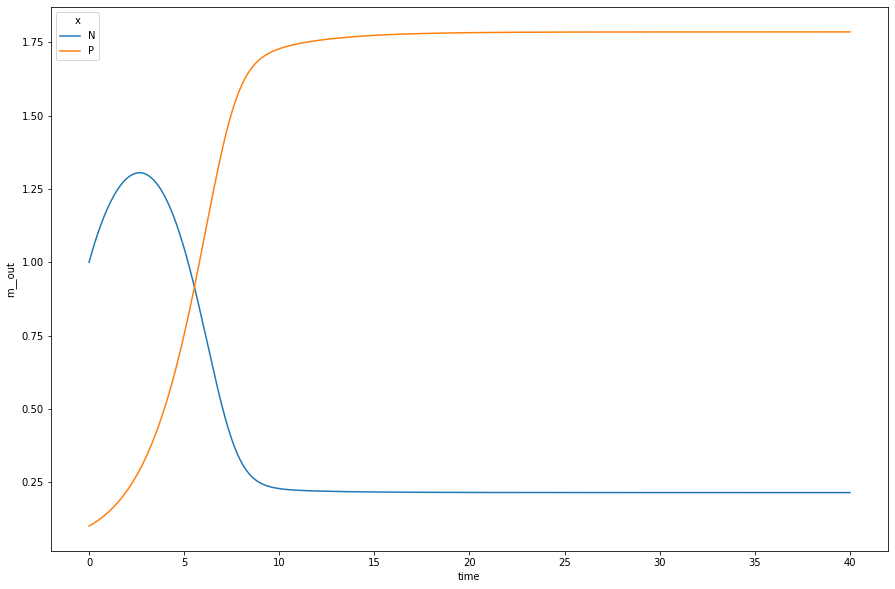

In [22]:
out.m__out.plot.line(x='time')

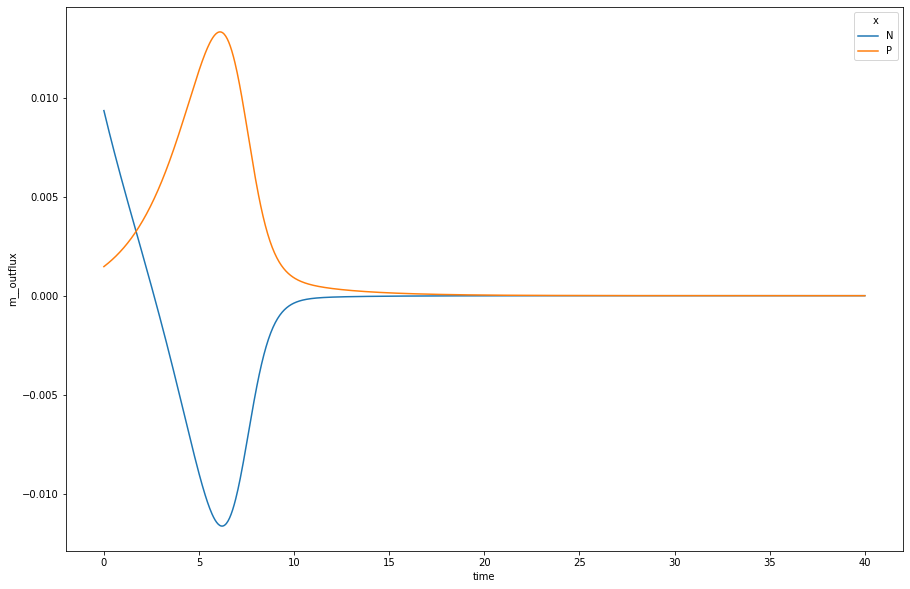

In [23]:
out.m__outflux.plot.line(x='time')

# Implement Fully within XSIMLAB framework

In [285]:
@xs.process
class Nutrient:
    label = xs.variable(default='N', groups='labels')
    
    flux = xs.variable(intent='out', groups='ODE-flux')
    
    num_nuts = xs.variable(intent='in')
    
    N0 = xs.variable(intent='inout', groups='ODE-term-constant', static=True)
    
    N_init = xs.variable(intent='inout', groups='ODE-term-init')
    
    def initialize(self):
        print('nuts init')
        self.flux = self._flux
        
    def _flux(self, *args):
        state, _ = args
        
        return(state[self.label] * 0.1)
        
        
        
 #dNdt = flow * N0 - nutuptake * P  - flow * N

In [286]:
@xs.process
class NutrientUptake:
    n_label = xs.foreign(Nutrient,'label')
    
    halfsat = xs.variable(groups='')

In [295]:
@xs.process
class Phytoplankton:
    label = xs.variable(default='P', groups='labels')
    
    flux = xs.variable(intent='out', groups='ODE-flux')
    
    num_phy = xs.variable(intent='in')
    
    P_init = xs.variable(intent='inout', groups='ODE-term-init')
    
    def initialize(self):
        print('phyto init')
        #print(self.label)
        self.flux = self._flux
        
    def _flux(self, *args):
        state, _ = args
        
        return(state[self.label]*0.1)#[self.label] * 1 + state[self.n_label])


#nutuptake = N / (halfsat + N) 

#dPdt = nutuptake * P - flow * P

In [296]:
@xs.process
class Chemostat:
    init = xs.group('ODE-term-init')
    odefluxes = xs.group('ODE-flux')
    c_labels = xs.group('labels')
    
    labels = xs.variable(
        dims='component',
        intent='out',
        description='component labels'
    )
    
    funcs = xs.variable(intent='out')
    state = xs.variable(intent='out')
    
    
    def initialize(self):
        print('chemostat init')
        self.labels = np.array(list(self.c_labels))

        
        self.state = {label: val for label, val in zip(self.labels, self.init)}
        
        # pick the right flux expression for each component
        self.funcs = {
            label: flux
            for label, flux in zip(self.labels, self.odefluxes)
        }
        print('state', self.state)
        print('funcs', self.funcs)
        #def ode(c, t):
        #    state = {label: val for label, val in zip(self.labels, c)}
        #    return [funcs[label](state, t) for label in self.labels]

    def run_step(self):
        print(self.labels)
        self.outflux = [self.funcs[label](self.state, 1) for label in self.labels]
        self.state = {label: self.state[label] + self.outflux[i] for label, i in zip(self.labels, range(len(self.labels)))} 
        print(self.state)


In [297]:
FirstModelSetup = xs.Model({'Env':Chemostat,'Phyto':Phytoplankton, 'Nuts':Nutrient})

In [298]:
# this is one way to create an lmfit.Parameter object:
parameters = Parameters()

parameters.add('Nuts__num_nuts', value=1,  vary=False)

parameters.add('Nuts__N0', value=2,  vary=False)

parameters.add('Nuts__N_init', value=1,  vary=False)

parameters.add('Phyto__num_phy', value=1, vary=False)

parameters.add('Phyto__P_init', value=0.1, vary=False)

In [299]:
def parameterDict2Input_vars(params):
    return {key : value for key, value in params.valuesdict().items()} 

In [300]:
parameterDict2Input_vars(parameters)

{'Nuts__num_nuts': 1,
 'Nuts__N0': 2,
 'Nuts__N_init': 1,
 'Phyto__num_phy': 1,
 'Phyto__P_init': 0.1}

In [301]:
FirstModelSetup_in = xs.create_setup(
 model=FirstModelSetup,
    clocks={
         'time': np.arange(0,5)
     },
    input_vars=
    parameterDict2Input_vars(parameters)
)

In [302]:
out = FirstModelSetup_in.xsimlab.run(model=FirstModelSetup)

nuts init
phyto init
chemostat init
state {'N': 1, 'P': 0.1}
funcs {'N': <bound method Nutrient._flux of <Nutrient 'Nuts' (xsimlab process)>
Variables:
    label        [in]
    flux        [out]
    num_nuts     [in]
    N0        [inout]
    N_init    [inout]
Simulation stages:
    initialize
>, 'P': <bound method Phytoplankton._flux of <Phytoplankton 'Phyto' (xsimlab process)>
Variables:
    label       [in]
    flux       [out]
    num_phy     [in]
    P_init   [inout]
Simulation stages:
    initialize
>}
['N' 'P']
{'N': 1.1, 'P': 0.11000000000000001}
['N' 'P']
{'N': 1.2100000000000002, 'P': 0.12100000000000002}
['N' 'P']
{'N': 1.3310000000000002, 'P': 0.13310000000000002}
['N' 'P']
{'N': 1.4641000000000002, 'P': 0.14641000000000004}


In [119]:
out

<xarray.Dataset>
Dimensions:         (time: 2)
Coordinates:
  * time            (time) int64 0 1
Data variables:
    Nuts__num_nuts  int64 1
    Nuts__N0        int64 2
    Nuts__N         int64 1
    Phyto__num_phy  int64 1
    Phyto__P        float64 0.1

In [217]:
@xs.process
class MODEL:
    x = xs.variable(dims='x', intent='inout')
    out = xs.variable(dims=('x'),intent='out')
    outflux = xs.variable(dims=('x'),intent='out')
    init = xs.variable(dims=('x'),intent='in')
    
    def initialize(self):
        self.out = self.init
        self.time = 0
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step with dt
        self.outflux = chemostat(self.time, self.out) * dt
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.out = np.array(self.out) + np.array(self.outflux)

# NEW TRY BELOW HERE

In [429]:
# NEW TRY: Let's keep all states in seperate object, that can then be called by each other process
#so that they can interact without a problem!

#ACTUALLY: i can do the same just by having a "LabelKeeper" object (This takes all the number and label setup stuff)



In [430]:
@xs.process
class NumberSetup:  
    num_nuts = xs.variable(intent='in', groups='num_components')
    num_phyto = xs.variable(intent='in',groups='num_components')
    
    N_init = xs.variable(intent='in', groups='input')
    P_init = xs.variable(intent='in', groups='input')   
    
    N_inputconc = xs.variable(intent='in', groups='input', static=True)
    flowrate = xs.variable(intent='in', groups='parameter', static=True)
    halfsat = xs.variable(intent='in', groups='parameter', static=True)
        
 #dNdt = flow * N0 - nutuptake * P  - flow * N

In [539]:
@xs.process
class ChemostatSetup:
    num_nuts = xs.foreign(NumberSetup, 'num_nuts')
    num_phyto = xs.foreign(NumberSetup, 'num_phyto')
    
    num_components = xs.variable(intent='out')
    
    Ninit = xs.foreign(NumberSetup, 'N_init')
    Pinit = xs.foreign(NumberSetup, 'P_init')
    
    N_init = xs.variable(dims='num_nuts', intent='out', groups='ODE-term-init')
    P_init = xs.variable(dims='num_phyto',intent='out', groups='ODE-term-init')      
    
    init = xs.variable(dims='components', intent='out')
    
    n_label = xs.variable(dims='num_nuts', intent='out', groups='label')
    p_label = xs.variable(dims='num_phyto',intent='out', groups='label')
    
    labels = xs.variable(dims='components', intent='out')
    
    #N = xs.variable(dims='num_nuts', intent='out', groups='ODE-term')
    #P = xs.variable(dims='num_phyto',intent='out', groups='ODE-term')
  
    def initialize(self):
        print('---Modelsetup init---')
        self.num_components = self.num_nuts + self.num_phyto
        self.n_label = ['N'+str(i+1) for i in range(self.num_nuts)]        
        self.p_label = ['P'+str(i+1) for i in range(self.num_phyto)]
        print(self.n_label, self.p_label)
        self.labels = np.concatenate([self.n_label,self.p_label])  # , axis=None)
        
        self.N_init = [self.Ninit for i in range(self.num_nuts)]
        self.P_init = [self.Pinit for i in range(self.num_phyto)]
        self.init = np.concatenate([self.N_init,self.P_init])  # , axis=None)
        print(self.labels)
        print(self.init)

In [704]:
@xs.process
class Component:
    
    flux = xs.variable(intent='out', groups='flux', description='ODE expression of component')
    num = xs.variable(intent='out')
    
    def _flux(self, state, time):
        """
        Parameters
        ----------
        state : dict
            Keys are ecosystem component labels and values are
            concentrations at current time.
        time : float
            Current time.

        """
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        self.flux = [self._flux for i in range(self.num)]

@xs.process
class Nutrients(Component):
    label = xs.foreign(ChemostatSetup, 'n_label')
    labels = xs.foreign(ChemostatSetup,'labels')
    init = xs.foreign(ChemostatSetup,'init')
    num = xs.foreign(NumberSetup, 'num_nuts')
    
    def _flux(self, *args):
        state,time = args
        print('Nut flux calc', state, self.label)
        return(state[self.label])
    
    #def initialize(self):
    #    print('---Nutrients init---')
    #    print([i for i in self.labels])
        
        
    
@xs.process
class Phytoplankton(Component):
    num_other = xs.foreign(NumberSetup, 'num_nuts')
    label = xs.foreign(ChemostatSetup, 'p_label')
    labels = xs.foreign(ChemostatSetup,'labels')
    init = xs.foreign(ChemostatSetup,'init')
    num = xs.foreign(NumberSetup, 'num_phyto')
    
    def _flux(self, *args):
        state,time = args
        print('Phyto flux calc', state, self.label)
        return(state[self.label[0]])
    
    class Phytoplankton(params):
        pass
    
    #def initialize(self):
    #    print('---Phytoplankton init---')
    #    print([i for i in self.init])

In [716]:
@xs.process
class Aggregate:
    N = xs.variable(intent='out')
    P = xs.variable(intent='out')
    
    def initialize(self):
        self.P = Phytoplankton()
        self.N = Phytoplankton()

In [718]:
Aggregate().initialize()

TypeError: __init__() missing 5 required keyword-only arguments: 'num_other', 'label', 'labels', 'init', and 'num'

In [705]:
@xs.process
class ModelSolver:
    components = xs.foreign(ChemostatSetup,'num_components')
    
    labels = xs.foreign(ChemostatSetup,'labels')
    init = xs.foreign(ChemostatSetup,'init')
    
    fluxes = xs.group('flux')
    fluxes_flat = xs.variable(dims=('components'),intent='out')
    
    state = xs.variable(dims=('components'),intent='out')
    outflux = xs.variable(dims=('components'),intent='out')
    
    def initialize(self):
        '---Model Solver init---'
        self.out = self.init
        print('init:',self.out)
        self.time = 0
        print('time:',self.time)
        
        print('labels')
        print(self.labels)
        print('fluxes_flat')
        #print(self.fluxes)
        self.fluxes_flat = np.concatenate([flux for flux in self.fluxes], axis=None)
        print(self.fluxes_flat)
        #print([flux for flux in self.fluxes_flat])

        self.state = {label: val for label, val in zip(self.labels, self.init)}
        
        self.funcs = {
            label: flux for label, flux in zip(self.labels, self.fluxes_flat)
        }
        
        print('state', self.state)
        print('funcs', self.funcs)

    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step with dt
        self.outflux = [self.funcs[label](self.state, self.time) for label in self.labels] * dt
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.state = {label: self.state[label] + self.outflux[i] for label, i in zip(self.labels, range(self.components))} 
        print(self.state)

In [706]:
chemostatModelSetup = xs.Model({'NS':NumberSetup, 'MS':ChemostatSetup, 'Nut':Nutrients, 'Phyto':Phytoplankton, 'ModelSolve':ModelSolver})

In [707]:
# this is one way to create an lmfit.Parameter object:
parameters = Parameters()

parameters.add('NS__num_nuts', value=1,  vary=False)
parameters.add('NS__num_phyto', value=2, vary=False)

parameters.add('NS__N_init', value=1,  vary=False)
parameters.add('NS__P_init', value=0.1, vary=False)

parameters.add('NS__N_inputconc', value=2,  vary=False)
parameters.add('NS__flowrate', value=0.2,  vary=False)
parameters.add('NS__halfsat', value=0.5,  vary=False)

In [708]:
def parameterDict2Input_vars(params):
    return {key : value for key, value in params.valuesdict().items()} 

In [709]:
parameterDict2Input_vars(parameters)

{'NS__num_nuts': 1,
 'NS__num_phyto': 2,
 'NS__N_init': 1,
 'NS__P_init': 0.1,
 'NS__N_inputconc': 2,
 'NS__flowrate': 0.2,
 'NS__halfsat': 0.5}

In [710]:
chemostatModelSetup_in = xs.create_setup(
 model=chemostatModelSetup,
    clocks={
         'time': np.arange(0,5)
     },
    input_vars=
    parameterDict2Input_vars(parameters)
)

In [711]:
[x for x in zip(b)]

[(<zip at 0x11c82d340>,), (<zip at 0x11c837a80>,)]

In [712]:
a = [0,1,2]
b = [zip(['a1']),zip(['b1','b2'])]
print([(a,b) for a,b in zip(a,np.concatenate(b, axis=None))])

[(0, <zip object at 0x11c840cc0>), (1, <zip object at 0x11c862b80>)]


In [713]:
out = chemostatModelSetup_in.xsimlab.run(model=chemostatModelSetup)

---Modelsetup init---
['N1'] ['P1', 'P2']
['N1' 'P1' 'P2']
[1.  0.1 0.1]
init: [1.  0.1 0.1]
time: 0
labels
['N1' 'P1' 'P2']
fluxes_flat
[<bound method Nutrients._flux of <Nutrients 'Nut' (xsimlab process)>
Variables:
    flux       [out] ODE expression of component
    label       [in] <--- MS.n_label
    labels      [in] <--- MS.labels
    init        [in] <--- MS.init
    num         [in] <--- NS.num_nuts
Simulation stages:
    initialize
>
 <bound method Phytoplankton._flux of <Phytoplankton 'Phyto' (xsimlab process)>
Variables:
    flux         [out] ODE expression of component
    num_other     [in] <--- NS.num_nuts
    label         [in] <--- MS.p_label
    labels        [in] <--- MS.labels
    init          [in] <--- MS.init
    num           [in] <--- NS.num_phyto
Simulation stages:
    initialize
>
 <bound method Phytoplankton._flux of <Phytoplankton 'Phyto' (xsimlab process)>
Variables:
    flux         [out] ODE expression of component
    num_other     [in] <--- NS.num_nut

TypeError: unhashable type: 'list'

In [551]:
out

<xarray.Dataset>
Dimensions:          (time: 5)
Coordinates:
  * time             (time) int64 0 1 2 3 4
Data variables:
    NS__num_nuts     int64 1
    NS__num_phyto    int64 2
    NS__N_init       int64 1
    NS__P_init       float64 0.1
    NS__N_inputconc  int64 2
    NS__flowrate     float64 0.2
    NS__halfsat      float64 0.5

# NEW 2nd TRY BELOW HERE

In [429]:
# NEW TRY: Let's keep all states in seperate object, that can then be called by each other process
#so that they can interact without a problem!

#ACTUALLY: i can do the same just by having a "LabelKeeper" object (This takes all the number and label setup stuff)



# WHAT I LEARNED FROM PREVIOUS TRY:

- I need to have it implemented so that each flux corresponds to one object that conatins it's own label
- this can either be done by moving the class structure for (Phytoplankton, etc. ) outside of the processes and instantiating multiple instances per "Bulk" class with flux

OR, and I think this is better;

- by passing multiple classes to each xs.Model() call, like {'P1':Phytoplankton,'P2':Phytoplankton,'P3':Phytoplankton}

- then there is one way to set common params (which are handled by bulk phyto class, so I can give all the same or specify each one)
- for a size-spectral model, it would be enough to pass one class like {'Phyto':AllometricSizePhyto}

In [4]:
@xs.process
class ChemostatParameters:
    N_init = xs.variable(intent='in')
    P_init = xs.variable(intent='in')  

    N_inputconc = xs.variable(intent='in', groups='input', static=True)
    flowrate = xs.variable(intent='in', groups='parameter', static=True)
    halfsat = xs.variable(intent='in', groups='parameter', static=True)
    
    P1_halfsat = xs.variable(intent='in', groups='parameter', static=True)
    P2_halfsat = xs.variable(intent='in', groups='parameter', static=True)
    P3_halfsat = xs.variable(intent='in', groups='parameter', static=True)

In [5]:
@xs.process
class Component:
    num = xs.variable(intent='out')
    label = xs.variable(intent='out', groups='label')
    flux = xs.variable(intent='out', groups='flux', description='ODE expression of component')
    init = xs.variable(intent='out', groups='init')
    
    def _flux(self, state, time):
        """
        Parameters
        ----------
        state : dict
            Keys are ecosystem component labels and values are
            concentrations at current time.
        time : float
            Current time.
        """
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        # this is a hack, ideally I would like to have some variable keeping track of all initialized components, but within each component in order
        global component_num
        
        self.num = component_num
        self.label = self.component_label + str(self.num)
        
        component_num += 1
        
        self.init = self.initVal
        self.flux = self._flux

In [6]:
@xs.process
class Nutrient(Component):
    component_label = xs.variable(default='N')
    initVal = xs.foreign(ChemostatParameters, 'N_init')
    
    N_inputconc = xs.foreign(ChemostatParameters, 'N_inputconc')
    flowrate = xs.foreign(ChemostatParameters, 'flowrate')
    halfsat = xs.foreign(ChemostatParameters, 'halfsat')
    
    def _flux(self, *args):
        state, time, labels = args
        P_labels = [plabel for plabel in labels if plabel[0] == 'P']
        Ps = sum([state[plabel] for plabel in P_labels])
        N = state[self.label]
        
        return(
        self.N_inputconc * self.flowrate - N / (N + self.halfsat) * Ps - self.flowrate * N
        )

@xs.process
class Phytoplankton(Component):
    component_label = xs.variable(default='P')
    initVal = xs.foreign(ChemostatParameters, 'P_init')
    
    N_inputconc = xs.foreign(ChemostatParameters, 'N_inputconc')
    flowrate = xs.foreign(ChemostatParameters, 'flowrate')
    halfsat = xs.foreign(ChemostatParameters, 'halfsat')
    
    def _flux(self, *args):
        state, time, labels = args
        N_labels = [nlabel for nlabel in labels if nlabel[0] == 'N']
        Ns = sum([state[nlabel] for nlabel in N_labels])
        P = state[self.label]
        
        return( 
        Ns / (Ns + self.halfsat) * P - self.flowrate * P
        )


In [7]:
@xs.process
class ModelSolver:
    labels = xs.group('label')
    init = xs.group('init')
    
    fluxes = xs.group('flux')
 
    component = xs.variable(dims=('component'), intent='out')
    
    state = xs.variable(dims=('component'),intent='out')
    stateout = xs.variable(dims=('component'),intent='out')
    outflux = xs.variable(dims=('component'),intent='out')
    
    def initialize(self):
        self.time = 0
        self.state = {label: val for label, val in zip(self.labels, self.init)}
        self.stateout = [self.state[label] for label in self.labels]
        self.funcs = {label: flux for label, flux in zip(self.labels, self.fluxes)}
        
        self.component = [i for i in self.labels]


    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step by multiplying by dt
        self.outflux = {label : self.funcs[label](self.state, self.time, self.labels) * dt for label in self.labels}
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.state = {label : self.state[label] + self.outflux[label] for label in self.labels}
        self.stateout = [self.state[label] for label in self.labels]
        #print(self.state)

In [8]:
# This should be the ideal setup way:
flextestModelSetup = xs.Model({'MS':ChemostatParameters,
                               'N1':Nutrient, 
                               'P1':Phytoplankton, 'P2':Phytoplankton, 'P3':Phytoplankton, 
                               'ModelSolver':ModelSolver})

In [50]:
flextestModelSetup.all_vars_dict

{'MS': ['N_init', 'P_init', 'N_inputconc', 'flowrate', 'halfsat'],
 'N1': ['num',
  'label',
  'flux',
  'init',
  'component_label',
  'initVal',
  'N_inputconc',
  'flowrate',
  'halfsat'],
 'P1': ['num',
  'label',
  'flux',
  'init',
  'component_label',
  'initVal',
  'N_inputconc',
  'flowrate',
  'halfsat'],
 'P2': ['num',
  'label',
  'flux',
  'init',
  'component_label',
  'initVal',
  'N_inputconc',
  'flowrate',
  'halfsat'],
 'P3': ['num',
  'label',
  'flux',
  'init',
  'component_label',
  'initVal',
  'N_inputconc',
  'flowrate',
  'halfsat'],
 'ModelSolver': ['labels',
  'init',
  'fluxes',
  'component',
  'state',
  'stateout',
  'outflux']}

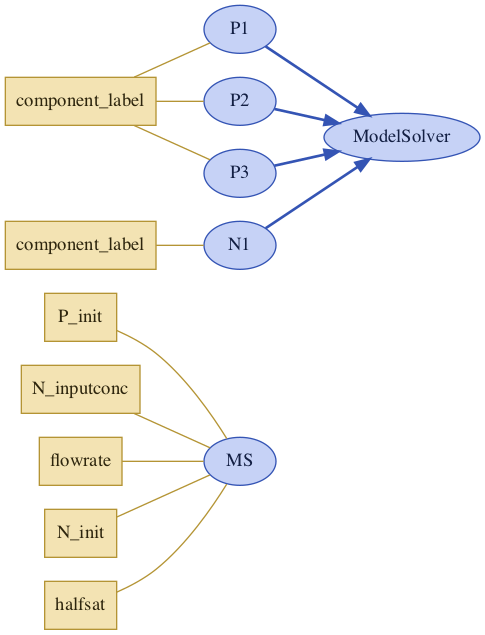

In [12]:
flextestModelSetup.visualize(show_inputs=True)

In [23]:
# this is one way to create an lmfit.Parameter object:
parameters = Parameters()

parameters.add('MS__N_init', value=1,  vary=False)
parameters.add('MS__P_init', value=0.1, vary=False)

parameters.add('MS__N_inputconc', value=2,  vary=False)
parameters.add('MS__flowrate', value=0.2,  vary=False)
parameters.add('MS__halfsat', value=0.5,  vary=False)


parameters.add('MS__P1_flowrate', value=0.2,  vary=False)

In [24]:
def parameterDict2Input_vars(params):
    params = {key : value for key, value in params.valuesdict().items()} 
    
    return params

In [25]:
parameterDict2Input_vars(parameters)

{'MS__N_init': 1,
 'MS__P_init': 0.1,
 'MS__N_inputconc': 2,
 'MS__flowrate': 0.2,
 'MS__halfsat': 0.5,
 'MS__P1_flowrate': 0.2}

In [16]:
flextestModelSetup_in = xs.create_setup(
 model=flextestModelSetup,
    clocks={
         'time': np.linspace(0,20,1000)
     },
    
    input_vars = parameterDict2Input_vars(parameters),
    
    output_vars={
        'ModelSolver__component' : None,
        'ModelSolver__stateout'  : 'time',
        'ModelSolver__outflux': 'time'
    }
    
)

In [17]:
component_num = 1
out = flextestModelSetup_in.xsimlab.run(model=flextestModelSetup)

In [18]:
out2 = out.set_index(component='ModelSolver__component')

In [19]:
out2

<xarray.Dataset>
Dimensions:                (component: 4, time: 1000)
Coordinates:
  * time                   (time) float64 0.0 0.02002 0.04004 ... 19.98 20.0
  * component              (component) object 'N1' 'P2' 'P3' 'P4'
Data variables:
    P2__component_label    <U1 'P'
    N1__component_label    <U1 'N'
    P3__component_label    <U1 'P'
    P1__component_label    <U1 'P'
    MS__N_init             int64 1
    MS__P_init             float64 0.1
    MS__N_inputconc        int64 2
    MS__flowrate           float64 0.2
    MS__halfsat            float64 0.5
    ModelSolver__stateout  (time, component) float64 1.0 0.1 ... 0.6204 0.6204
    ModelSolver__outflux   (time) object {'N1': 0.0, 'P2': 0.0009342676009342675, 'P3': 0.0009342676009342675, 'P4': 0.0009342676009342675} ... {'N1': -4.753622309054897e-06, 'P2': 1.8627641981626635e-05, 'P3': 1.8627641981626635e-05, 'P4': 1.8627641981626635e-05}

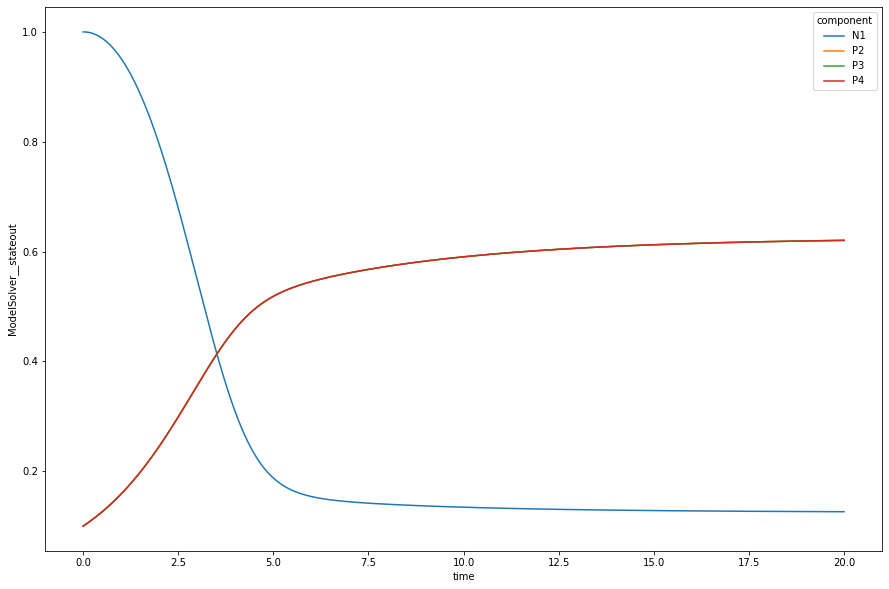

In [20]:
out2.ModelSolver__stateout.plot.line(x='time')

In [ ]:
# notes

- nutrient flexibility this way actually does not make all that much sense
instead the nutrients need to be hard coded into the model structure, i.e N1: 'Nitrate', N2:'Phosphate', N3:'Silicate'
            and it checks for duplicate implementations, that don't make sense
            
- i.e. full flexibility only necessary for PFTs + Zoo

In [ ]:
# TODO

- finish model schematics & send around
- implement a structure that checks for necessary parameters, and gives a list of all necessary ones

In [26]:
@xs.process
class Testit:
    label = xs.variable(intent='in')

In [31]:
mod = xs.Model({"X1":Testit,"X2":Testit})

In [34]:
mod

<xsimlab.Model (2 processes, 2 inputs)>
X1
    label       [in]
X2
    label       [in]

In [46]:
mod.all_vars_dict

{'X1': ['label'], 'X2': ['label']}

In [35]:
# this is one way to create an lmfit.Parameter object:
parameters = Parameters()

parameters.add('X1__label', value=1,  vary=False)
parameters.add('X2__label', value=0.1, vary=False)

In [40]:
def parameterDict2Input_vars(params,model):
    params = {key : value for key, value in params.valuesdict().items()} 
    model.all_vars_dict
    return params

In [41]:
parameterDict2Input_vars(parameters,mod)

AttributeError: 'Model' object has no attribute 'get_process_dependencies'